__author__ = 'Ricardo Pasquini'

# Counting tweets at the hexagon level. Complete procedure

Overview: This code counts georeferenced tweets at the hexagon level. Hexagons are uniquely identified in space. We use Uber's H3 library for this purpose.  
The code  also performs a home location prediction for each user. This allows later counting tweets by whether they were tweeted by residents, residents of neighbors hexagons, or non-residents.
The project was designed to be scalable to millions of tweets. The process is done with MongoDB.

By default the project generates the following collections on the Mongo database:

tweets: Collection containing tweets. This collection is modified by incorporating the corresponding hex id. \
users: Collection containing users. This collection is modified by incorporating the home location data.\
hexcounts: Collection containing counts of tweets.


In [1]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3

In [13]:
import importlib
importlib.reload(databasepopulation)
importlib.reload(home)
importlib.reload(a)
importlib.reload(myh3)

<module 'my_h3_functions' from '../my_h3_functions.py'>

# Counting tweets at the hexagon level. Complete procedure

This version of the code assumes that a different database will be used for each city.


If necessary check your current location with the following command:

In [3]:
 !pwd

/mnt/c/Users/Richard/Drive/projects/twitter/notebooks


# 0. Connect to Mongo and define a specific database

By default connect to Mongo running on a localhost. 
Requires manually changing the parameters if working on a cloud environment

I will use the name buenosaires as the db example. Recall each database for each city.


In [3]:
db=commu.connecttoLocaldb(database='twitter')

# 1. Raw data to Mongo
This function populates the files containing tweets into Mongo.
Assumes files are named like: ba_2012.csv, etc.
Choose start and end years.


In [10]:
databasepopulation.populatetweets(db, path='/mnt/d/twitter/', cityprefix='ba', yearstart=2015, yearend=2015)


Now populating year  2015
process completed


# 2. Adding Hexids to tweets 
This function includes hexagons ids to each tweet.  

In [40]:
databasepopulation.addhexjob(db)

 iter: 1  time: 0.22681570053100586
 iter: 2  time: 0.21671772003173828
 iter: 3  time: 0.2405691146850586
 iter: 4  time: 0.31368541717529297
 iter: 5  time: 0.27761077880859375
 iter: 6  time: 0.26112890243530273
 iter: 7  time: 0.22281408309936523
 iter: 8  time: 0.1968994140625
 iter: 9  time: 0.3073241710662842
 iter: 10  time: 0.22986364364624023
 iter: 11  time: 0.6346921920776367
 iter: 12  time: 0.3234543800354004
 iter: 13  time: 0.26929235458374023
 iter: 14  time: 0.21526741981506348
 iter: 15  time: 0.18408441543579102
 iter: 16  time: 0.20883941650390625
 iter: 17  time: 0.1782221794128418
 iter: 18  time: 0.20904302597045898
 iter: 19  time: 0.18248629570007324
 iter: 20  time: 0.28961730003356934
 iter: 21  time: 0.20610713958740234
 iter: 22  time: 0.1990804672241211
 iter: 23  time: 0.2217543125152588
 iter: 24  time: 0.34151649475097656
 iter: 25  time: 0.18855738639831543
 iter: 26  time: 0.2612776756286621
 iter: 27  time: 0.19443297386169434
 iter: 28  time: 0.248

 iter: 222  time: 0.24240994453430176
 iter: 223  time: 0.18688249588012695
 iter: 224  time: 0.18803095817565918
 iter: 225  time: 0.23665189743041992
 iter: 226  time: 0.1896977424621582
 iter: 227  time: 0.18918442726135254
 iter: 228  time: 0.23843836784362793
 iter: 229  time: 0.19916486740112305
 iter: 230  time: 0.18266034126281738
 iter: 231  time: 0.1859571933746338
 iter: 232  time: 0.19191622734069824
 iter: 233  time: 0.17608118057250977
 iter: 234  time: 0.1799468994140625
 iter: 235  time: 0.21285176277160645
 iter: 236  time: 0.17495274543762207
 iter: 237  time: 0.2613091468811035
 iter: 238  time: 0.24863028526306152
 iter: 239  time: 0.17458248138427734
 iter: 240  time: 0.19231867790222168
 iter: 241  time: 0.16782402992248535
 iter: 242  time: 0.26495909690856934
 iter: 243  time: 0.16640567779541016
 iter: 244  time: 0.20889687538146973
 iter: 245  time: 0.170180082321167
 iter: 246  time: 0.2502164840698242
 iter: 247  time: 0.1844339370727539
 iter: 248  time: 0.

 iter: 442  time: 0.18553900718688965
 iter: 443  time: 0.16589117050170898
 iter: 444  time: 0.18423199653625488
 iter: 445  time: 0.19298243522644043
 iter: 446  time: 0.17166829109191895
 iter: 447  time: 0.1706836223602295
 iter: 448  time: 0.17926263809204102
 iter: 449  time: 0.17778944969177246
 iter: 450  time: 0.1854391098022461
 iter: 451  time: 0.17664837837219238
 iter: 452  time: 0.20370244979858398
 iter: 453  time: 0.16173148155212402
 iter: 454  time: 0.1796102523803711
 iter: 455  time: 0.17112278938293457
 iter: 456  time: 0.17576169967651367
 iter: 457  time: 0.1693274974822998
 iter: 458  time: 0.17146086692810059
 iter: 459  time: 0.19830322265625
 iter: 460  time: 0.18302369117736816
 iter: 461  time: 0.16973423957824707
 iter: 462  time: 0.18474268913269043
 iter: 463  time: 0.1646871566772461
 iter: 464  time: 0.18137121200561523
 iter: 465  time: 0.16420483589172363
 iter: 466  time: 0.2139132022857666
 iter: 467  time: 0.16913628578186035
 iter: 468  time: 0.1

 iter: 660  time: 0.24750280380249023
 iter: 661  time: 0.18868303298950195
 iter: 662  time: 0.27356576919555664
 iter: 663  time: 0.20892024040222168
 iter: 664  time: 0.18094396591186523
 iter: 665  time: 0.19944405555725098
 iter: 666  time: 0.17201948165893555
 iter: 667  time: 0.17838358879089355
 iter: 668  time: 0.18673467636108398
 iter: 669  time: 0.29266905784606934
 iter: 670  time: 0.1799302101135254
 iter: 671  time: 0.1859126091003418
 iter: 672  time: 0.21998000144958496
 iter: 673  time: 0.18451523780822754
 iter: 674  time: 0.20268583297729492
 iter: 675  time: 0.4348313808441162
 iter: 676  time: 0.2006683349609375
 iter: 677  time: 0.18675923347473145
 iter: 678  time: 0.22118544578552246
 iter: 679  time: 0.18838143348693848
 iter: 680  time: 0.1833937168121338
 iter: 681  time: 0.18024086952209473
 iter: 682  time: 0.23058724403381348
 iter: 683  time: 0.2419421672821045
 iter: 684  time: 0.2447953224182129
 iter: 685  time: 0.1804502010345459
 iter: 686  time: 0.

 iter: 878  time: 0.2401742935180664
 iter: 879  time: 0.24909090995788574
 iter: 880  time: 0.17066407203674316
 iter: 881  time: 0.18466496467590332
 iter: 882  time: 0.16529321670532227
 iter: 883  time: 0.17844891548156738
 iter: 884  time: 0.19143271446228027
 iter: 885  time: 0.17539191246032715
 iter: 886  time: 0.19785785675048828
 iter: 887  time: 0.20235371589660645
 iter: 888  time: 0.16669797897338867
 iter: 889  time: 0.19983649253845215
 iter: 890  time: 0.2625386714935303
 iter: 891  time: 0.35063862800598145
 iter: 892  time: 0.2893853187561035
 iter: 893  time: 0.3216822147369385
 iter: 894  time: 0.25447607040405273
 iter: 895  time: 0.1843092441558838
 iter: 896  time: 0.24501729011535645
 iter: 897  time: 0.1995983123779297
 iter: 898  time: 0.17865252494812012
 iter: 899  time: 0.5196187496185303
 iter: 900  time: 0.20398855209350586
 iter: 901  time: 0.2754678726196289
 iter: 902  time: 0.16682147979736328
 iter: 903  time: 0.18809866905212402
 iter: 904  time: 0.

 iter: 1095  time: 0.26432275772094727
 iter: 1096  time: 0.3132815361022949
 iter: 1097  time: 0.17441582679748535
 iter: 1098  time: 0.17563223838806152
 iter: 1099  time: 0.1997823715209961
 iter: 1100  time: 0.2356100082397461
 iter: 1101  time: 0.19370436668395996
 iter: 1102  time: 0.2722334861755371
 iter: 1103  time: 0.339580774307251
 iter: 1104  time: 0.2322220802307129
 iter: 1105  time: 0.17844009399414062
 iter: 1106  time: 0.2028045654296875
 iter: 1107  time: 0.17295479774475098
 iter: 1108  time: 0.260636568069458
 iter: 1109  time: 0.28089237213134766
 iter: 1110  time: 0.31050968170166016
 iter: 1111  time: 0.2082347869873047
 iter: 1112  time: 0.31910204887390137
 iter: 1113  time: 0.30735325813293457
 iter: 1114  time: 0.192030668258667
 iter: 1115  time: 0.19902420043945312
 iter: 1116  time: 0.25474977493286133
 iter: 1117  time: 0.217085599899292
 iter: 1118  time: 0.36094045639038086
 iter: 1119  time: 1.0817115306854248
 iter: 1120  time: 0.18248224258422852
 i

 iter: 1308  time: 0.1830756664276123
 iter: 1309  time: 0.18120503425598145
 iter: 1310  time: 0.18780803680419922
 iter: 1311  time: 0.17777705192565918
 iter: 1312  time: 0.18513226509094238
 iter: 1313  time: 0.2633824348449707
 iter: 1314  time: 0.18208789825439453
 iter: 1315  time: 0.18272066116333008
 iter: 1316  time: 0.17182660102844238
 iter: 1317  time: 0.23805809020996094
 iter: 1318  time: 0.17535924911499023
 iter: 1319  time: 0.21683669090270996
 iter: 1320  time: 0.22321319580078125
 iter: 1321  time: 0.17805242538452148
 iter: 1322  time: 0.18317532539367676
 iter: 1323  time: 0.1757192611694336
 iter: 1324  time: 0.1900954246520996
 iter: 1325  time: 0.23941659927368164
 iter: 1326  time: 0.1817018985748291
 iter: 1327  time: 0.44568395614624023
 iter: 1328  time: 0.17880511283874512
 iter: 1329  time: 0.17926740646362305
 iter: 1330  time: 0.20857524871826172
 iter: 1331  time: 0.18081116676330566
 iter: 1332  time: 0.18108677864074707
 iter: 1333  time: 0.175556659

 iter: 1522  time: 0.2834773063659668
 iter: 1523  time: 0.30273914337158203
 iter: 1524  time: 0.16438674926757812
 iter: 1525  time: 0.4910109043121338
 iter: 1526  time: 0.17787694931030273
 iter: 1527  time: 0.28374671936035156
 iter: 1528  time: 0.27652883529663086
 iter: 1529  time: 0.327129602432251
 iter: 1530  time: 0.3900105953216553
 iter: 1531  time: 0.3214397430419922
 iter: 1532  time: 0.3147163391113281
 iter: 1533  time: 0.25254106521606445
 iter: 1534  time: 0.16883444786071777
 iter: 1535  time: 0.18772029876708984
 iter: 1536  time: 0.16606616973876953
 iter: 1537  time: 0.23415303230285645
 iter: 1538  time: 0.18967151641845703
 iter: 1539  time: 0.24137067794799805
 iter: 1540  time: 0.3571913242340088
 iter: 1541  time: 0.17873620986938477
 iter: 1542  time: 0.19606995582580566
 iter: 1543  time: 0.29219746589660645
 iter: 1544  time: 0.2918238639831543
 iter: 1545  time: 0.17966556549072266
 iter: 1546  time: 0.20766472816467285
 iter: 1547  time: 0.1893131732940

 iter: 1735  time: 0.2283768653869629
 iter: 1736  time: 0.3269503116607666
 iter: 1737  time: 0.24706268310546875
 iter: 1738  time: 0.23518943786621094
 iter: 1739  time: 0.35106587409973145
 iter: 1740  time: 0.3356606960296631
 iter: 1741  time: 0.2849256992340088
 iter: 1742  time: 0.25886011123657227
 iter: 1743  time: 0.3075375556945801
 iter: 1744  time: 0.42000699043273926
 iter: 1745  time: 0.33300185203552246
 iter: 1746  time: 0.22574329376220703
 iter: 1747  time: 0.30893921852111816
 iter: 1748  time: 0.1978914737701416
 iter: 1749  time: 0.27133870124816895
 iter: 1750  time: 0.24179840087890625
 iter: 1751  time: 0.2442951202392578
 iter: 1752  time: 0.3441321849822998
 iter: 1753  time: 0.3304440975189209
 iter: 1754  time: 0.30570292472839355
 iter: 1755  time: 0.23169398307800293
 iter: 1756  time: 0.4707958698272705
 iter: 1757  time: 0.4628725051879883
 iter: 1758  time: 0.3689992427825928
 iter: 1759  time: 0.41432905197143555
 iter: 1760  time: 0.5235893726348877

 iter: 1949  time: 0.19112253189086914
 iter: 1950  time: 0.2483670711517334
 iter: 1951  time: 0.2112107276916504
 iter: 1952  time: 0.18624186515808105
 iter: 1953  time: 0.19150471687316895
 iter: 1954  time: 0.4487721920013428
 iter: 1955  time: 0.20509862899780273
 iter: 1956  time: 0.2109229564666748
 iter: 1957  time: 0.23848176002502441
 iter: 1958  time: 0.2686295509338379
 iter: 1959  time: 0.38056159019470215
 iter: 1960  time: 0.21190619468688965
 iter: 1961  time: 0.18697237968444824
 iter: 1962  time: 0.30235815048217773
 iter: 1963  time: 0.17738127708435059
 iter: 1964  time: 0.3246026039123535
 iter: 1965  time: 0.32118916511535645
 iter: 1966  time: 0.2060229778289795
 iter: 1967  time: 0.1781916618347168
 iter: 1968  time: 0.19074487686157227
 iter: 1969  time: 0.184800386428833
 iter: 1970  time: 0.2269737720489502
 iter: 1971  time: 0.2960991859436035
 iter: 1972  time: 0.1840839385986328
 iter: 1973  time: 0.20572209358215332
 iter: 1974  time: 0.17206120491027832

 iter: 2162  time: 0.25771212577819824
 iter: 2163  time: 0.336087703704834
 iter: 2164  time: 0.46906352043151855
 iter: 2165  time: 0.6787419319152832
 iter: 2166  time: 0.486572265625
 iter: 2167  time: 1.1351511478424072
 iter: 2168  time: 0.4185450077056885
 iter: 2169  time: 0.3335602283477783
 iter: 2170  time: 0.33973145484924316
 iter: 2171  time: 0.1765737533569336
 iter: 2172  time: 0.18253731727600098
 iter: 2173  time: 0.17849016189575195
 iter: 2174  time: 0.22900056838989258
 iter: 2175  time: 0.17908382415771484
 iter: 2176  time: 0.18961358070373535
 iter: 2177  time: 0.3215792179107666
 iter: 2178  time: 0.1965031623840332
 iter: 2179  time: 0.2212238311767578
 iter: 2180  time: 0.3506734371185303
 iter: 2181  time: 0.21898412704467773
 iter: 2182  time: 0.17419791221618652
 iter: 2183  time: 0.24143505096435547
 iter: 2184  time: 0.4948568344116211
 iter: 2185  time: 0.1805553436279297
 iter: 2186  time: 0.22697734832763672
 iter: 2187  time: 0.17674684524536133
 ite

 iter: 2376  time: 0.187391996383667
 iter: 2377  time: 0.4902651309967041
 iter: 2378  time: 0.26798319816589355
 iter: 2379  time: 0.18152523040771484
 iter: 2380  time: 0.35814404487609863
 iter: 2381  time: 0.19360756874084473
 iter: 2382  time: 0.20511651039123535
 iter: 2383  time: 0.2802402973175049
 iter: 2384  time: 0.26381516456604004
 iter: 2385  time: 0.18666291236877441
 iter: 2386  time: 0.19069671630859375
 iter: 2387  time: 0.20534825325012207
 iter: 2388  time: 0.1906423568725586
 iter: 2389  time: 0.25728416442871094
 iter: 2390  time: 0.2809927463531494
 iter: 2391  time: 0.32979369163513184
 iter: 2392  time: 0.22014570236206055
 iter: 2393  time: 0.1788649559020996
 iter: 2394  time: 0.18429303169250488
 iter: 2395  time: 0.17250537872314453
 iter: 2396  time: 0.28649282455444336
 iter: 2397  time: 0.24270057678222656
 iter: 2398  time: 0.24580740928649902
 iter: 2399  time: 0.30121827125549316
 iter: 2400  time: 0.2704920768737793
 iter: 2401  time: 0.283556222915

 iter: 2589  time: 0.3457818031311035
 iter: 2590  time: 0.4403798580169678
 iter: 2591  time: 0.23970413208007812
 iter: 2592  time: 0.6522314548492432
 iter: 2593  time: 0.5329828262329102
 iter: 2594  time: 0.37474679946899414
 iter: 2595  time: 0.4575793743133545
 iter: 2596  time: 0.39900803565979004
 iter: 2597  time: 0.3899216651916504
 iter: 2598  time: 0.5385138988494873
 iter: 2599  time: 0.6592814922332764
 iter: 2600  time: 0.5538485050201416
 iter: 2601  time: 1.3070571422576904
 iter: 2602  time: 1.7791798114776611
 iter: 2603  time: 0.5399734973907471
 iter: 2604  time: 0.5213987827301025
 iter: 2605  time: 0.40697646141052246
 iter: 2606  time: 0.3989729881286621
 iter: 2607  time: 0.20500922203063965
 iter: 2608  time: 0.2833280563354492
 iter: 2609  time: 0.262709379196167
 iter: 2610  time: 0.3498823642730713
 iter: 2611  time: 0.5205497741699219
 iter: 2612  time: 0.18868136405944824
 iter: 2613  time: 0.20215654373168945
 iter: 2614  time: 0.255281925201416
 iter: 

 iter: 2803  time: 0.28143739700317383
 iter: 2804  time: 0.20099711418151855
 iter: 2805  time: 0.6737499237060547
 iter: 2806  time: 0.17410063743591309
 iter: 2807  time: 0.184617280960083
 iter: 2808  time: 0.172318696975708
 iter: 2809  time: 0.21189117431640625
 iter: 2810  time: 0.18150854110717773
 iter: 2811  time: 0.2300434112548828
 iter: 2812  time: 0.17081022262573242
 iter: 2813  time: 0.19423604011535645
 iter: 2814  time: 0.17355680465698242
 iter: 2815  time: 0.17871928215026855
 iter: 2816  time: 0.27170276641845703
 iter: 2817  time: 0.19618916511535645
 iter: 2818  time: 0.21248650550842285
 iter: 2819  time: 0.17307543754577637
 iter: 2820  time: 0.20014643669128418
 iter: 2821  time: 0.9490196704864502
 iter: 2822  time: 0.17913174629211426
 iter: 2823  time: 0.19629120826721191
 iter: 2824  time: 0.179046630859375
 iter: 2825  time: 0.22170543670654297
 iter: 2826  time: 0.1780991554260254
 iter: 2827  time: 0.22674345970153809
 iter: 2828  time: 0.17228245735168

 iter: 3016  time: 0.25509166717529297
 iter: 3017  time: 0.17358779907226562
 iter: 3018  time: 0.19652390480041504
 iter: 3019  time: 0.19690728187561035
 iter: 3020  time: 0.22900676727294922
 iter: 3021  time: 0.21040558815002441
 iter: 3022  time: 0.1775808334350586
 iter: 3023  time: 0.18794465065002441
 iter: 3024  time: 0.1671898365020752
 iter: 3025  time: 0.17818212509155273
 iter: 3026  time: 0.24502205848693848
 iter: 3027  time: 0.1746072769165039
 iter: 3028  time: 0.47936582565307617
 iter: 3029  time: 0.18770051002502441
 iter: 3030  time: 0.18492388725280762
 iter: 3031  time: 0.30167269706726074
 iter: 3032  time: 0.18676543235778809
 iter: 3033  time: 0.35594725608825684
 iter: 3034  time: 0.19105291366577148
 iter: 3035  time: 0.20425128936767578
 iter: 3036  time: 0.17696547508239746
 iter: 3037  time: 0.18201732635498047
 iter: 3038  time: 0.17446613311767578
 iter: 3039  time: 0.23470759391784668
 iter: 3040  time: 0.5087947845458984
 iter: 3041  time: 0.18017172

 iter: 3229  time: 0.18213629722595215
 iter: 3230  time: 0.17753839492797852
 iter: 3231  time: 0.21648216247558594
 iter: 3232  time: 0.1900463104248047
 iter: 3233  time: 0.2940363883972168
 iter: 3234  time: 0.20749759674072266
 iter: 3235  time: 0.489168643951416
 iter: 3236  time: 0.22326254844665527
 iter: 3237  time: 0.2501354217529297
 iter: 3238  time: 0.28455185890197754
 iter: 3239  time: 0.1779944896697998
 iter: 3240  time: 0.2731297016143799
 iter: 3241  time: 0.18101143836975098
 iter: 3242  time: 0.3875765800476074
 iter: 3243  time: 0.4037463665008545
 iter: 3244  time: 0.19993948936462402
 iter: 3245  time: 0.3546180725097656
 iter: 3246  time: 0.30118560791015625
 iter: 3247  time: 0.1827096939086914
 iter: 3248  time: 0.20051980018615723
 iter: 3249  time: 0.17448163032531738
 iter: 3250  time: 0.1881260871887207
 iter: 3251  time: 0.18726801872253418
 iter: 3252  time: 0.22204089164733887
 iter: 3253  time: 0.18149590492248535
 iter: 3254  time: 0.1959056854248047

 iter: 3443  time: 0.2821383476257324
 iter: 3444  time: 0.41986680030822754
 iter: 3445  time: 0.5043478012084961
 iter: 3446  time: 0.34568095207214355
 iter: 3447  time: 0.3950169086456299
 iter: 3448  time: 0.3397800922393799
 iter: 3449  time: 0.2757868766784668
 iter: 3450  time: 0.26758337020874023
 iter: 3451  time: 0.2037038803100586
 iter: 3452  time: 0.22530293464660645
 iter: 3453  time: 0.20925545692443848
 iter: 3454  time: 0.21829533576965332
 iter: 3455  time: 0.6485931873321533
 iter: 3456  time: 0.26557111740112305
 iter: 3457  time: 0.18237972259521484
 iter: 3458  time: 0.3568897247314453
 iter: 3459  time: 0.3628087043762207
 iter: 3460  time: 0.45288634300231934
 iter: 3461  time: 1.176145315170288
 iter: 3462  time: 0.23463654518127441
 iter: 3463  time: 0.1844937801361084
 iter: 3464  time: 0.19559502601623535
 iter: 3465  time: 0.18024516105651855
 iter: 3466  time: 0.19373774528503418
 iter: 3467  time: 0.2921113967895508
 iter: 3468  time: 0.16890692710876465

In [ ]:
# the following is a check and a fix because I think the previous process did not run completely, probably a bug.
# are there any other documents that were not processed?
len(list(db.tweets.find({ "hex" : { "$exists" : False } })))

In [80]:
#Process any missing document
cursor=db.tweets.find({ "hex" : { "$exists" : False } })
df = pd.DataFrame(list(cursor))
requests = databasepopulation.add_hexs_and_prepare_bulk_request(df, dataformat='raw')
try:
    db.tweets.bulk_write(requests, ordered=False)
except BulkWriteError as bwe:
    print(bwe.details)

# 3. Database performance task: Add indexes to tweets

In [51]:
databasepopulation.create_indexes(db)

'u_id_1'

# 4. Populate Users Collection

In [60]:
databasepopulation.populate_users_collection(db)

# 5. Find Home Job for each user id in the database

In [ ]:
home.job_findhomeandpopulate_hex9(db)

In [99]:
print('Users with home location identified', db.users.count_documents({'hex9': { '$exists': True} }))


Users with home location identified 16467


# 6 Generate a Hex-level collection including all hexs in the database

By default the collection include as ids only the ids of hexagons at resolution 9
Note that many types of hexogons could coexist in a same collection because hex identifiers are unique. This is not implemented in the current version of the code, though.

In [102]:
databasepopulation.populate_hexcounts_collection(db)


# 7 Count tweets in each hex by residents and non-residents

In [103]:
import analysis as a

In [115]:
a.countandpopulatejob(db)

Hexagons pending to analyze.. 8733
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350
iter: 400
iter: 450
iter: 500
iter: 550
iter: 600
iter: 650
iter: 700
iter: 750
iter: 800
iter: 850
iter: 900
iter: 950
iter: 1000
iter: 1050
iter: 1100
iter: 1150
iter: 1200
iter: 1250
iter: 1300
iter: 1350
iter: 1400
iter: 1450
iter: 1500
iter: 1550
iter: 1600
iter: 1650
iter: 1700
iter: 1750
iter: 1800
iter: 1850
iter: 1900
iter: 1950
iter: 2000
iter: 2050
iter: 2100
iter: 2150
iter: 2200
iter: 2250
iter: 2300
iter: 2350
iter: 2400
iter: 2450
iter: 2500
iter: 2550
iter: 2600
iter: 2650
iter: 2700
iter: 2750
iter: 2800
iter: 2850
iter: 2900
iter: 2950
iter: 3000
iter: 3050
iter: 3100
iter: 3150
iter: 3200
iter: 3250
iter: 3300
iter: 3350
iter: 3400
iter: 3450
iter: 3500
iter: 3550
iter: 3600
iter: 3650
iter: 3700
iter: 3750
iter: 3800
iter: 3850
iter: 3900
iter: 3950
iter: 4000
iter: 4050
iter: 4100
iter: 4150
iter: 4200
iter: 4250
iter: 4300
iter: 4350
iter: 4400
iter: 4450
iter: 

# 8 Query to the DB to create the counts dataframe 

In [14]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)
# if save=True then saves resulting dataframe a pickle in ./hexcountsdf.pkl

1.2720601558685303


In [15]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,89dd686e037ffff,1388448000000,1.0,1.0,NaN,1.0,2013-12-31
1,89dd686e0b3ffff,1388448000000,10.0,10.0,NaN,10.0,2013-12-31
2,89dd6b840b3ffff,1388448000000,1.0,1.0,NaN,1.0,2013-12-31
3,89dd6b98cb3ffff,1388448000000,1.0,1.0,NaN,1.0,2013-12-31
4,89dd682f35bffff,1388448000000,3.0,3.0,NaN,3.0,2013-12-31


# Funcions for Spatial Analysis

## A. Transform the dataframe with hexids into a geodataframe with hexagons as geometries 

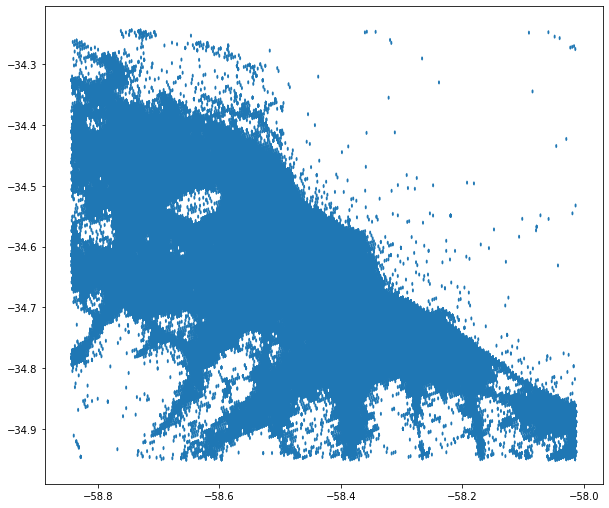

In [156]:
hexgdf=myh3.df_with_hexid_to_gdf(df, hexcolname='_id')
hexgdf.plot()

In [157]:
hexgdf.head()

,time,_id,count,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,geometry
0,2013-12-31,89dd686e037ffff,1,1.0,1.0,NaN,1,POLYGON ((-58.63403773176579 -34.2683973430459...
1,2013-12-31,89dd686e0b3ffff,10,10.0,10.0,NaN,10,POLYGON ((-58.64339994048145 -34.2718676697477...
2,2013-12-31,89dd686eed3ffff,6,NaN,NaN,6.0,6,POLYGON ((-58.61431268091515 -34.2722761407819...
3,2013-12-31,89dd6b840b3ffff,1,1.0,1.0,NaN,1,POLYGON ((-58.28815662988858 -34.9164620764708...
4,2013-12-31,89dd6b98cb3ffff,1,1.0,1.0,NaN,1,POLYGON ((-58.46230598961161 -34.5167196289263...


## B. Transform the dataframe with hexids into a geodataframe with centoids points as geometries 
Points can be used for spatial joins.

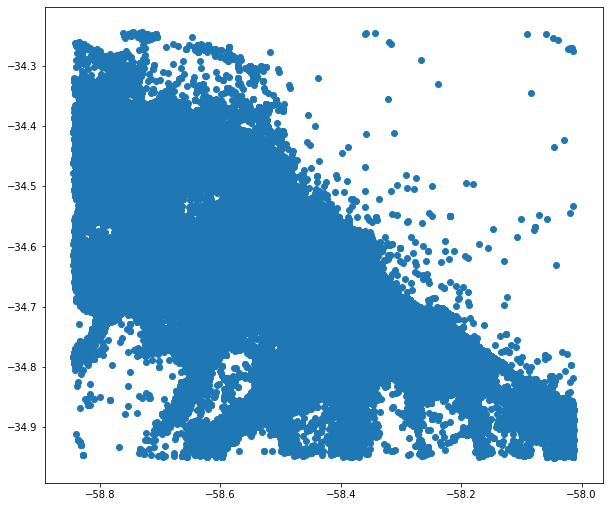

In [26]:
centroidsgdf=myh3.df_with_hexid_to_centroids_gdf(hexgdf, hexcolname='_id')
centroidsgdf.plot()

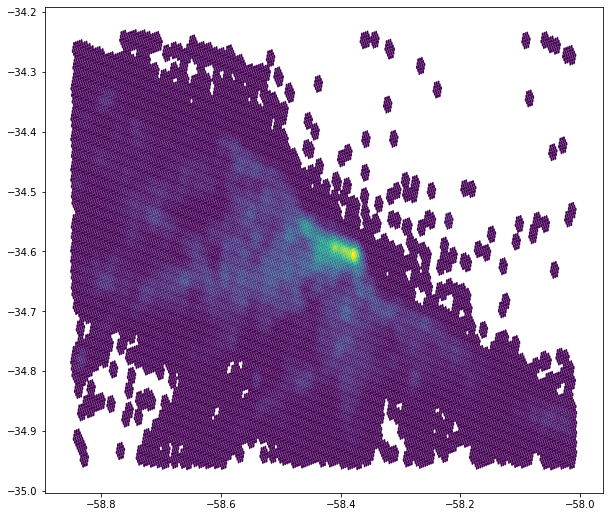

In [34]:
smooth_hexgdf=myh3.kring_smoother(hexgdf, hexcolname='_id',  metric_col='nonresidents')
smooth_hexgdf.plot(column='nonresidents')